Auteur : David Paulino
# Expected Goals
Ce Jupyter Notebook a pour but d'être un support pour la rédaction du Travail de Bachelor nommé "Analyse et optimisation de l'expected goal : application au machine learning" 

Assurez-vous d'avoir installé les librairies suivantes :
- numpy
- pandas
- matplotlib
- mplsoccer
- sklearn

In [372]:
# Import des libs
import pandas as pd
import numpy as np
import json
# Plotting
import matplotlib.pyplot as plt
# Permet de plot des terrains de football
from mplsoccer import VerticalPitch, Pitch
# Nécessaire à l'import des datasets
import os
import pathlib
import seaborn as sns
# Sklearn
from sklearn.model_selection import train_test_split
# Cross validation pour la recherche des hyperparamètres
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
# Standardisation des données
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
# Import scoring methods
from sklearn.metrics import make_scorer, log_loss
# DummyClassifier
from sklearn.dummy import DummyClassifier

# Gestion des couleurs des heatmaps
import matplotlib.colors as mcolors

# Permet d'éviter les warnings
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Données
La première partie de notebook vise à importer, visualiser et observer les caractéristiques de chacun des attributs du dataset. Cela va permettre de mieux comprendre le dataset dans son ensemble, d'observer d'éventuelles données manquantes et de pouvoir prédire à l'avance d'éventuels comportements.

In [222]:
# Chargement des données events
train = pd.DataFrame()
mypath = os.path.join(str(pathlib.Path().resolve().parents[0]), 'expected-goals', 'events')

# Permet de récupérer tous les fichiers dans le dossier /TB/events
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
for file_name in onlyfiles:
    path_to_file = mypath + "/" + file_name
    
    with open(path_to_file) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])

In [223]:
# Chargement des données de joueurs
players = pd.DataFrame()
mypath = os.path.join(str(pathlib.Path().resolve().parents[0]), 'expected-goals', 'players')

# Insérer les données du fichier players.json dans le dataframe players
with open(mypath + "/players.json") as f:
    data = json.load(f)
    players = pd.DataFrame(data)


Maintenant, nous allons filtrer uniquement par les données qui nous intéressent, à savoir les tirs.
On utilise "subEventName" pour retirer les penaltys.

In [224]:
shots = train[train["subEventName"] == "Shot"]


In [225]:
print(shots.shape)

(43078, 12)


# Pré-visualisation
## Position des tirs

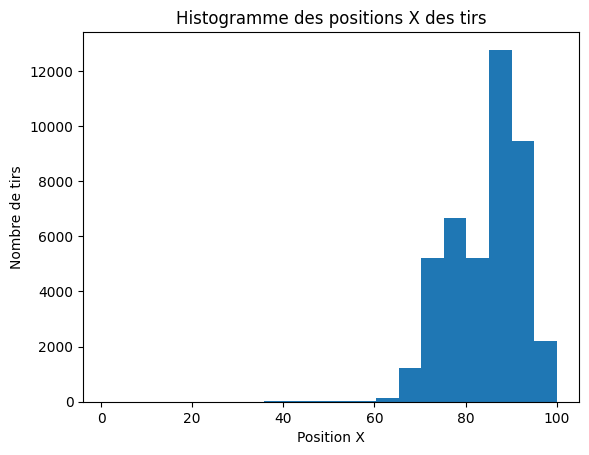

In [226]:
# Histogramme des positions X des tirs
# X représente la longueur du terrain malgré le fait que le terrain soit en 100x100

x_pos = shots["positions"].apply(lambda x: x[0]["x"])
plt.hist(x_pos, bins=20)
plt.title("Histogramme des positions X des tirs")
plt.xlabel("Position X")
plt.ylabel("Nombre de tirs")
#plt.ylim(0, 10)
plt.show()

On peut voir que tous les tirs sont effectuées dans la partie haute du terrain. Cependant, il est important de noter que les tirs ont été normalisés par rapport au sens du but. Ainsi, tous les tirs effectués dans le but adverse sont considérés comme des tirs dans la partie haute du terrain. On peut notamment le voir dans le graphique qui suit.

Text(0.5, 1.0, 'Positions des 1000 premiers tirs')

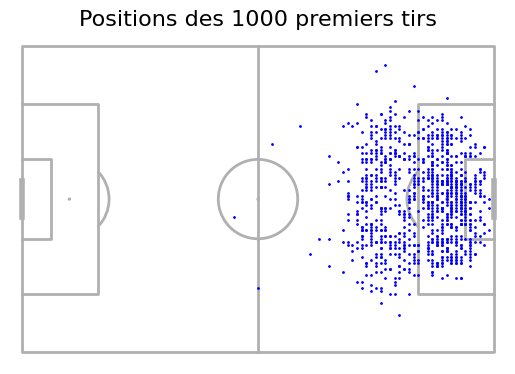

In [227]:
# Affichage des 1000 premibers tirs sur un terrain
# On peut voir qu'ils sont tous dans une seule moitié de terrain alors qu'un match se joue dans les deux sens
# Les données utilisées viennent de Wyscout

pitch = Pitch(pitch_type='wyscout')

fig, ax = pitch.draw(constrained_layout=True, tight_layout=False)

pitch.scatter(x_pos[:1000], shots["positions"].apply(lambda x: x[0]["y"])[:1000], ax=ax, s=1, color='blue')
ax.set_title("Positions des 1000 premiers tirs", fontsize=16)

# Transformation des données
Le but de la transformation de données est de convertir les positions X et Y en mètres. Suite à cela, nous allons pouvoir calculer la distance entre le tireur et le but adverse. Ensuite, nous allons également calculer l'angle de tir. Ces deux nouvelles caractéristiques vont nous permettre d'établir correctement un modèle d'expected goals.

In [228]:
# Taille du terrain
pitch_size = (105, 68)
# On transforme d'abord les positions des tirs correctements
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * pitch_size[0]/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * pitch_size[1]/100)
# Utile pour le calcul de la distance au but et de l'angle de tir
# L'attribut C est un équivalent de Y mais il permet de situer le but en position 0, 0
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * pitch_size[1]/100)
#print(shots[["X", "Y", "C"]].head())

In [229]:
# Les coordonnées du but sont (0, 50). On peut le voir sur le glossaire de Wyscout dans "Pitch Coordinates"
# Cependant, on a besoin de les transformer pour qu'elles soient dans le même format que les positions des tirs
# Pour rappel, la taille du terrain est de 105x68
# On choisit également le but en 0, 50 car cela nous permettra de calculer l'angle du tir par rapport au but
goal_coordinates = np.array([0*pitch_size[0]/100, 50*pitch_size[1]/100])
print(goal_coordinates)

# Largeur du but
goal_width = 7.32
# On calcule la distance entre le but et le tir avec la dimension 105x68
shots["distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)

# Calcul de l'angle avec la fonction utilisée et expliqué dans la thèse.
shots["angle"] = np.pi - \
                    (np.arctan( (shots["C"] - goal_width/2) / shots["X"]) + np.pi/2) - \
                    (np.pi/2 - np.arctan( (shots["C"] + goal_width/2) / shots["X"]))
# Angle basé sur le centre du terrain
shots["angle_abs"] = np.pi - np.arctan(shots["C"] / shots["X"])

shots["goal"] = shots["tags"].apply(lambda cell: 101 in [tag["id"] for tag in cell])

shots["header"] = shots["tags"].apply(lambda cell: 403 in [tag["id"] for tag in cell])

def extract_good_foot(tags):
    for tag in tags:
        if tag['id'] == 401:
            return 'left'
        elif tag['id'] == 402:
            return 'right'
    return None  # Retourne None si aucun pied correspondant n'est trouvé

shots["foot_used_on_shot"] = shots["tags"].apply(extract_good_foot)



[ 0. 34.]


# Fusion des datasets

In [230]:
# Le but de la fusion de dataset est de récupérer les informations des joueurs qui ont tiré
# Parmi ces informations on va récupérer le pied fort du joueur
# On va donc comparer si le pied fort du joueur est le même que le pied utilisé pour tirer

# On récupère les informations des joueurs qui ont tiré
shots = shots.merge(players[["wyId", "foot"]], left_on="playerId", right_on="wyId", how="inner")
# On calcule quel est le bon pied pour chaque tir
shots["good_foot_used"] = shots["foot"] == shots["foot_used_on_shot"]

# On passe les colonnes en int
shots["good_foot_used"] = shots["good_foot_used"].astype(int)
shots["header"] = shots["header"].astype(int)
shots["goal"] = shots["goal"].astype(int)



In [231]:
# On prend uniquement les attributs qui nous intéressent
shots = shots[["X", "Y", "distance", "angle", "angle_abs", "goal", "header", "good_foot_used"]]

print(shots[10:20])

                        

        X      Y   distance     angle  angle_abs  goal  header  good_foot_used
10  26.25  42.16  27.489054  0.253313   2.840205     0       0               1
11  25.20  42.84  26.705535  0.257736   2.804211     0       0               0
12  15.75  22.44  19.537044  0.303370   2.508431     1       0               1
13  19.95  46.92  23.768233  0.258838   2.566893     0       0               1
14  17.85  46.24  21.643477  0.279618   2.540519     0       0               1
15   9.45  46.24  15.463509  0.297367   2.228266     0       0               1
16  25.20  40.80  26.101341  0.269474   2.878029     0       0               1
17   7.35  40.80  10.013116  0.554534   2.395044     0       0               1
18  12.60  19.72  19.044117  0.258168   2.293776     0       0               1
19   7.35  27.88   9.564356  0.603340   2.447256     0       1               0


# Visualisation des données
## Description des données numériques

In [232]:
shots.describe()

,X,Y,distance,angle,angle_abs,goal,header,good_foot_used
count,43075.000000,43075.000000,43075.000000,43075.000000,43075.000000,43075.000000,43075.000000,43075.000000
mean,15.992225,33.473176,18.593067,0.414140,2.657552,0.104283,0.162159,0.646477
std,8.534333,9.366171,8.419298,0.253173,0.313051,0.305631,0.368601,0.478069
min,0.000000,0.000000,0.680000,0.000000,1.570796,0.000000,0.000000,0.000000
25%,9.450000,26.520000,12.249445,0.250188,2.441817,0.000000,0.000000,0.000000
50%,13.650000,33.320000,17.153297,0.327782,2.689439,0.000000,0.000000,1.000000
75%,23.100000,40.800000,24.936000,0.505984,2.914297,0.000000,0.000000,1.000000
max,103.950000,68.000000,103.952224,3.141593,3.141593,1.000000,1.000000,1.000000


## Position de tous les tirs sous formes de heatmap

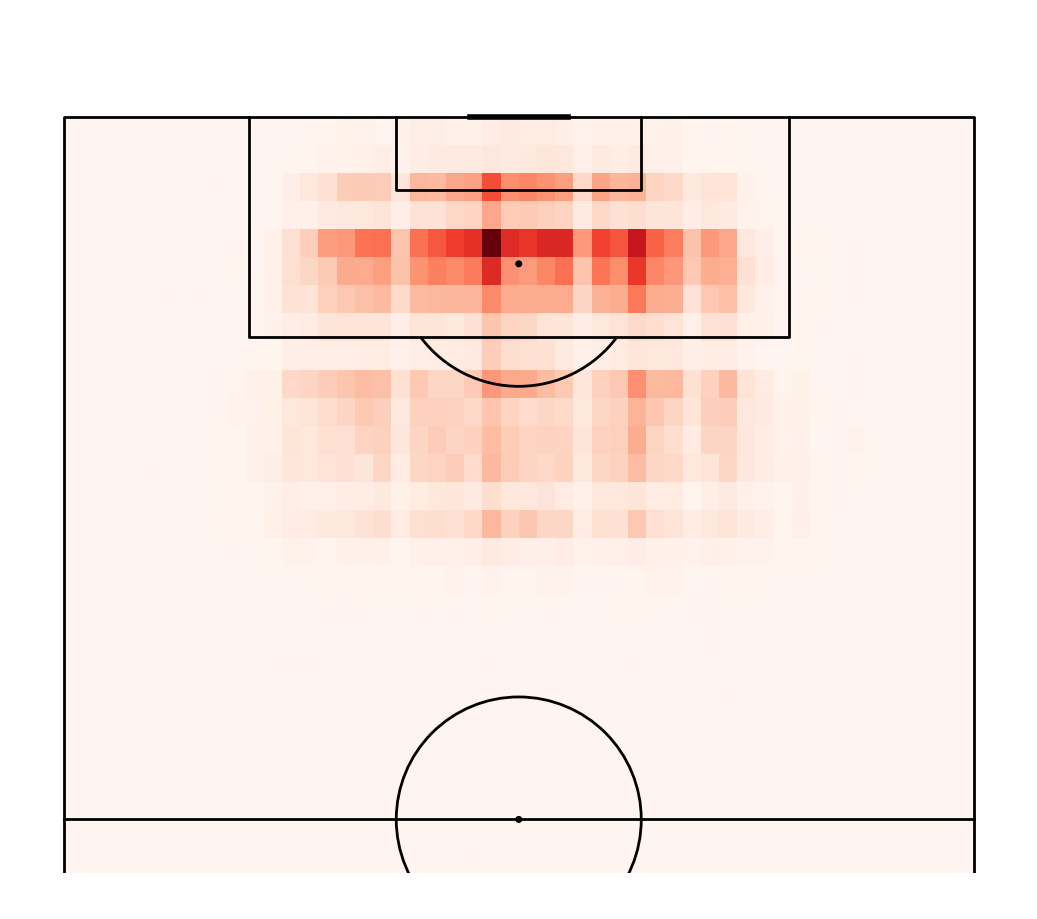

In [233]:
# Le but est d'afficher une moitié de terrain avec une heatmap qui montre la fréquence des positions des tirs

# On crée un terrain avec la librairie mplsoccer. La taille du terrain est de 105x68
# On doit obligatoirement mettre "line_zorder = 2" pour que le terrain soit affiché correctement sur la heatmap
pitch = VerticalPitch(line_color="black", pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2, half=True)

# Il faut mettre une grille sur le terrain pour pouvoir afficher la heatmap
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# On affiche la heatmap avec la fonction heatmap de la librairie mplsoccer
# On prépare les données avec la fonction bin_statistic qui permet de compter le nombre de tirs dans chaque case
# 105-shots.X car autrement les tirs sont affichés de l'autre côté du terrain
bin_statistics_shot = pitch.bin_statistic(105-shots.X, shots.Y, bins=(50, 50))
pitch.heatmap(bin_statistics_shot, ax=ax["pitch"], cmap='Reds', edgecolors='white', linewidth=0)


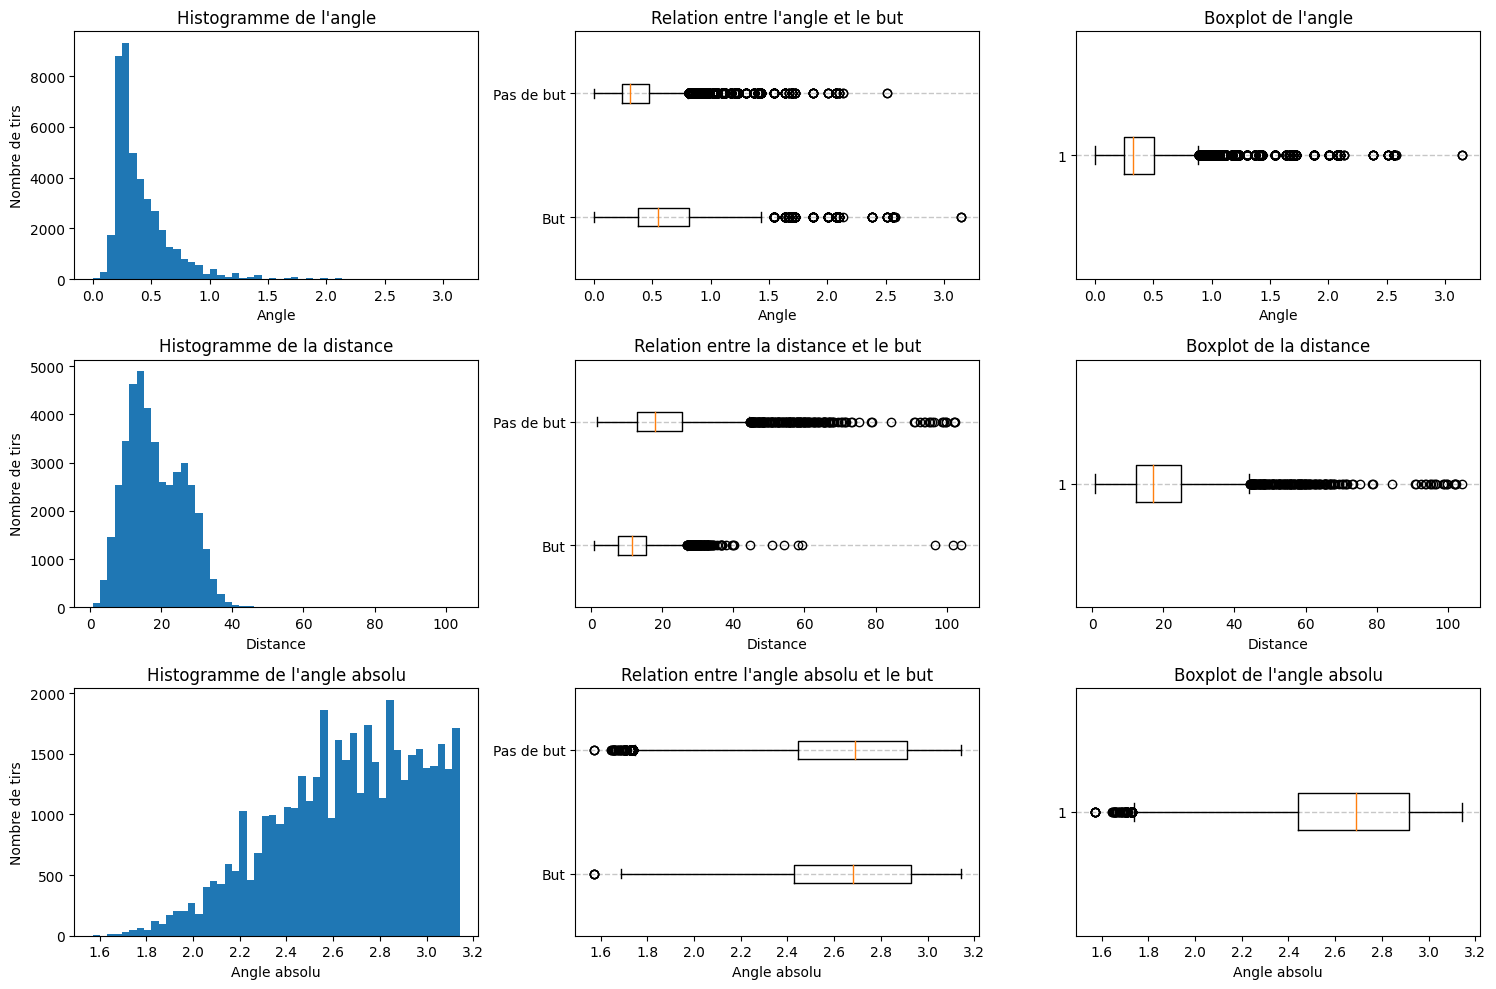

In [234]:
import matplotlib.pyplot as plt

# Créer un subplot avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Histogramme de l'angle
axes[0,0].hist(shots["angle"], bins=50)
axes[0,0].set_xlabel("Angle")
axes[0,0].set_ylabel("Nombre de tirs")
axes[0,0].set_title("Histogramme de l'angle")


# # Affichage d'un boxplot par valeur possible de goal pour l'angle
axes[0,1].boxplot([shots[shots["goal"] == True]["angle"], shots[shots["goal"] == False]["angle"]], vert=False)
axes[0,1].set_xlabel("Angle")
axes[0,1].set_title("Relation entre l'angle et le but")
# Changer le nom des catégories
axes[0,1].set_yticks([1, 2], ["But", "Pas de but"])
axes[0,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
# Affichage d'un boxplot pour l'angle
axes[0,2].boxplot(shots["angle"], vert=False)
axes[0,2].set_xlabel("Angle")
axes[0,2].set_title("Boxplot de l'angle")
axes[0,2].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Histogramme de la distance
axes[1,0].hist(shots["distance"], bins=50)
axes[1,0].set_xlabel("Distance")
axes[1,0].set_ylabel("Nombre de tirs")
axes[1,0].set_title("Histogramme de la distance")

# Affichage d'un boxplot par valeur possible de goal pour la distance
axes[1,1].boxplot([shots[shots["goal"] == True]["distance"], shots[shots["goal"] == False]["distance"]], vert=False)
axes[1,1].set_xlabel("Distance")
axes[1,1].set_title("Relation entre la distance et le but")
# Changer le nom des catégories
axes[1,1].set_yticks([1, 2], ["But", "Pas de but"])
axes[1,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
# Affichage d'un boxplot pour la distance
axes[1,2].boxplot(shots["distance"], vert=False)
axes[1,2].set_xlabel("Distance")
axes[1,2].set_title("Boxplot de la distance")
axes[1,2].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Histogramme de la distance
axes[2,0].hist(shots["angle_abs"], bins=50)
axes[2,0].set_xlabel("Angle absolu")
axes[2,0].set_ylabel("Nombre de tirs")
axes[2,0].set_title("Histogramme de l'angle absolu")

# Affichage d'un boxplot par valeur possible de goal pour l'angle
axes[2,1].boxplot([shots[shots["goal"] == True]["angle_abs"], shots[shots["goal"] == False]["angle_abs"]], vert=False)
axes[2,1].set_xlabel("Angle absolu")
axes[2,1].set_title("Relation entre l'angle absolu et le but")
# Changer le nom des catégories
axes[2,1].set_yticks([1, 2], ["But", "Pas de but"])
axes[2,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
# Affichage d'un boxplot pour l'angle absolu
axes[2,2].boxplot(shots["angle_abs"], vert=False)
axes[2,2].set_xlabel("Angle absolu")
axes[2,2].set_title("Boxplot de l'angle absolu")
axes[2,2].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()

# Afficher le subplot
plt.show()

In [235]:
# Methode pour trouver les outliers
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)]
    return outliers

# Lister les outliers
outliers_distance = find_outliers(shots, "distance")
outliers_angle = find_outliers(shots, "angle")
outliers_angle_abs = find_outliers(shots, "angle_abs")

# Afficher le nombre d'outliers
print("Nombre d'outliers pour la distance :", len(outliers_distance))
print("Nombre d'outliers pour l'angle :", len(outliers_angle))
print("Nombre d'outliers pour l'angle absolu :", len(outliers_angle_abs))





Nombre d'outliers pour la distance : 197
Nombre d'outliers pour l'angle : 2163
Nombre d'outliers pour l'angle absolu : 70


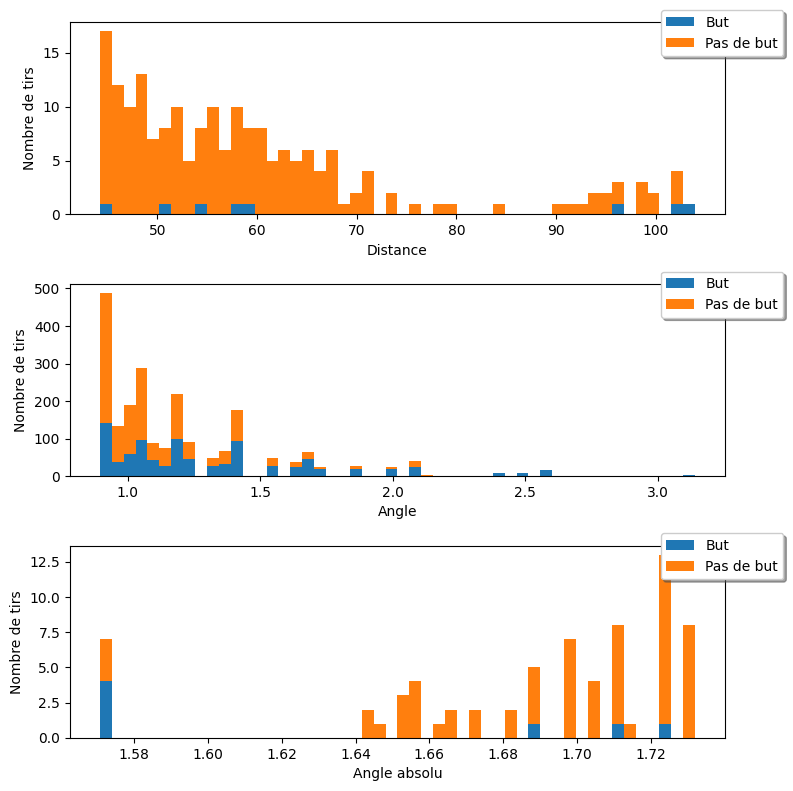

In [236]:
# Barplot de la proportion des buts marqués pour l'outlier de la distance
fig, ax = plt.subplots(3, figsize=(8, 8))
ax[0].hist([
        outliers_distance[outliers_distance["goal"] == True]["distance"], 
        outliers_distance[outliers_distance["goal"] == False]["distance"]], 
        bins=50, 
        stacked=True, 
        label=["But", "Pas de but"])
ax[0].set_xlabel("Distance")
ax[0].set_ylabel("Nombre de tirs")
ax[0].legend(
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# On peut remarquer qu'il y a uniquement 3 buts qui sont fait à une 
# très haute distance. Sachant que l'on peut observer que le reste des tirs
# à cette distance n'ont pas été marqué, on peut supposer que ces 3 buts
# sont des outliers.

ax[1].hist([
        outliers_angle[outliers_angle["goal"] == True]["angle"], 
        outliers_angle[outliers_angle["goal"] == False]["angle"]], 
        bins=50, 
        stacked=True, 
        label=["But", "Pas de but"])
ax[1].set_xlabel("Angle")
ax[1].set_ylabel("Nombre de tirs")
ax[1].legend(
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# On remarque qu'il n'y a pas grand chose à dire sur ces outliers.
# Plus l'angle est grand plus il y a de buts mais on voit sur l'histogramme
# que la proportion de buts marqués est similaires à celle des buts manqués. au même angle
# Barplot de la proportion des buts marqués pour l'outlier de la distance
ax[2].hist([
        outliers_angle_abs[outliers_angle_abs["goal"] == True]["angle_abs"], 
        outliers_angle_abs[outliers_angle_abs["goal"] == False]["angle_abs"]], 
        bins=50, 
        stacked=True, 
        label=["But", "Pas de but"])
ax[2].set_xlabel("Angle absolu")
ax[2].set_ylabel("Nombre de tirs")
ax[2].legend(
        loc='upper right',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# Pareil que pour l'angle, il n'y a pas grand chose à dire sur ce graphique.
plt.tight_layout()
plt.show()


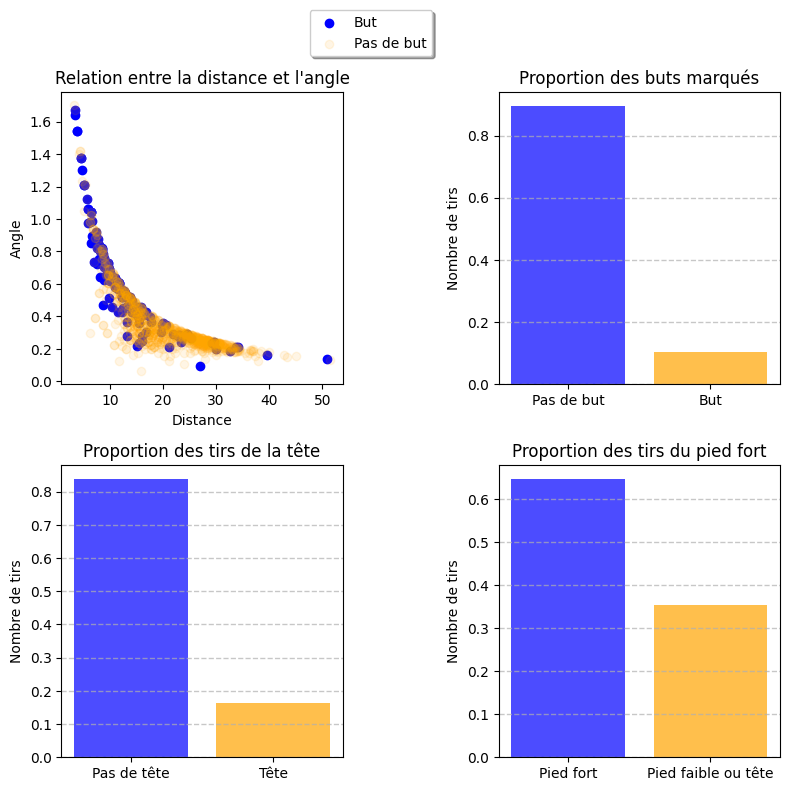

In [237]:
# Affichage des autres graphiques
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Affichage de la relation entre la distance et l'angle
# Les points en bleu seront uniquement les buts marqués
# Les points en orange seront uniquement les buts manqués
first_1000_shots = shots[:1000]

ax[0,0].scatter(
        first_1000_shots[first_1000_shots["goal"] == True]["distance"],
        first_1000_shots[first_1000_shots["goal"] == True]["angle"],
        c="blue",
        label="But",
        alpha=1)
ax[0,0].scatter(
        first_1000_shots[first_1000_shots["goal"] == False]["distance"],
        first_1000_shots[first_1000_shots["goal"] == False]["angle"],
        c="orange",
        label="Pas de but",
        alpha=0.1)
ax[0,0].set_xlabel("Distance")
ax[0,0].set_ylabel("Angle")
ax[0,0].set_title("Relation entre la distance et l'angle")
ax[0,0].legend(
        loc='lower center',
        bbox_to_anchor=(1.1, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True)

# Barplot pour afficher la proportion des buts

counting_values = shots["goal"].value_counts(normalize=True)
ax[0,1].bar(
        ["Pas de but", "But"],
        counting_values,
        color=["blue", "orange"],
        alpha=0.7)
ax[0,1].set_ylabel("Nombre de tirs")
ax[0,1].set_title("Proportion des buts marqués")
ax[0,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Affichage d'un barplot pour la proportion des tirs de la tête
counting_values = shots["header"].value_counts(normalize=True)
ax[1,0].bar(
        ["Pas de tête", "Tête"],
        counting_values,
        color=["blue", "orange"],
        alpha=0.7)
ax[1,0].set_ylabel("Nombre de tirs")
ax[1,0].set_title("Proportion des tirs de la tête")
ax[1,0].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

# Affichage d'un barplot pour la proportion des tirs du pied fort
counting_values = shots["good_foot_used"].value_counts(normalize=True)
ax[1,1].bar(
        ["Pied fort", "Pied faible ou tête"],
        counting_values,
        color=["blue", "orange"],
        alpha=0.7)
ax[1,1].set_ylabel("Nombre de tirs")
ax[1,1].set_title("Proportion des tirs du pied fort")
ax[1,1].grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)




plt.tight_layout()
plt.show()


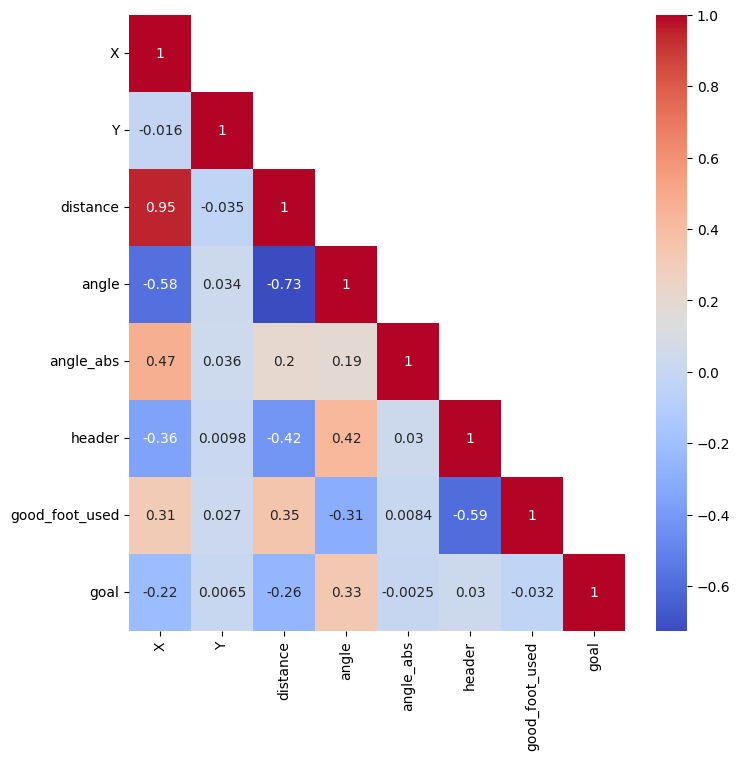

In [238]:
# Matrice de corrélation de tout le dataset
# Goal à la fin du dataset pour simplifier la visualisation
shots = shots[["X", "Y", "distance", "angle", "angle_abs", "header", "good_foot_used", "goal"]]

corr = shots.corr()
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm", mask=np.triu(corr, k=1))
plt.show()

# Via cette matrice de corrélation on peut voir que la distance et l'angle
# ont une grande corrélation pour déterminer si un tir est un but ou non.
# C'est également le cas pour la position X. et c'est normal puisque
# elle est étroitement corrélé avec la distance

## Suppression des outliers

In [239]:
# Suppression des outliers pour la distance
# On va supprimer les outliers qui ont une distance supérieur à 90 mètres et qui sont des buts
print("Nombre de tirs avant suppression :", len(shots))
shots = shots.drop(shots[(shots["distance"] > 90) & (shots["goal"] == True)].index)
print("Nombre de tirs après suppression :", len(shots))
# On a bien supprimé les trois outliers de la distanceb

Nombre de tirs avant suppression : 43075
Nombre de tirs après suppression : 43072


# Modèle d'expected goals
## Séparation des données en train et test

In [240]:
# Nous devons d'abord créer une séparation entre les données d'entrainement et de test
# On va utiliser la fonction train_test_split de sklearn
# On va utiliser 90% des données pour l'entrainement et 10% pour le test
X = shots.drop("goal", axis=1)
y = shots["goal"]

# Le test sera utilisé pour la validation finale du modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



In [241]:
# Proportion de buts marqués dans le dataset de test
print("Proportion de buts marqués dans le dataset de test :", y_test.value_counts(normalize=True))
print("Proportion de buts marqués dans le dataset de train :", y_train.value_counts(normalize=True))

Proportion de buts marqués dans le dataset de test : goal
0    0.89415
1    0.10585
Name: proportion, dtype: float64
Proportion de buts marqués dans le dataset de train : goal
0    0.89596
1    0.10404
Name: proportion, dtype: float64


In [242]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# On définit la méthode d'évaluation des modèles
# On va utiliser la log loss
# En indiquant greater_is_better=False, on indique que plus la log loss est petite, mieux c'est.
# Cependant, dans ce cas précis, il va inverser le signe de la méthode donnée pour le scoring
scoring_method = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

## Sélection des meilleurs attributs

In [243]:
# On va créer une régression logistique
# qui va nous permettre d'observer les p-values
# et de voir si les variables sont significatives
new_X = sm.add_constant(X_train)

specific_columns = ["const", "distance", "angle", "header", "good_foot_used" ]

for i in range(1, len(specific_columns)+1):
    log_reg = sm.Logit(y_train, new_X[specific_columns[:i]])
    result = log_reg.fit()
    print(result.summary())

Optimization terminated successfully.
         Current function value: 0.333870
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                38764
Model:                          Logit   Df Residuals:                    38763
Method:                           MLE   Df Model:                            0
Date:                Fri, 16 Jun 2023   Pseudo R-squ.:               1.138e-12
Time:                        02:16:05   Log-Likelihood:                -12942.
converged:                       True   LL-Null:                       -12942.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1531      0.017   -129.428      0.000      -2.186      -2.121
Optimization terminated succe

In [244]:
# On retire les attributs qui ne sont pas significatifs
print(X)
X = X.drop(["X", "Y", "angle_abs"], axis=1)
print(X)
# On recrée les données d'entrainement et de test pour retirer les attributs non significatifs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

           X      Y   distance     angle  angle_abs  header  good_foot_used
0       6.30  38.76   7.896050  0.755576   2.494545       0               1
1      13.65  46.24  18.334124  0.300230   2.410602       0               1
2      29.40  40.80  30.176150  0.235417   2.914297       0               1
3      28.35  23.80  30.129097  0.227998   2.796224       0               1
4      12.60  29.92  13.244108  0.517537   2.828438       0               0
...      ...    ...        ...       ...        ...     ...             ...
43070  26.25  55.76  34.096336  0.165676   2.449445       0               1
43071   4.20  52.36  18.834267  0.089828   1.795685       1               0
43072  29.40  27.20  30.176150  0.235417   2.914297       0               1
43073  13.65  32.64  13.717584  0.519343   3.042287       0               0
43074  26.25  41.48  27.294924  0.256837   2.863998       0               1

[43072 rows x 7 columns]
        distance     angle  header  good_foot_used
0       7.8

## Recherche des meilleurs hyper paramètres                                                                                                     
### Régression logistique

In [254]:
hyperparameters = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.1, 1.0, 10.0, 100.0],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [100, 200, 300, 500],
}



log_reg = LogisticRegression()

# On va utiliser la fonction GridSearchCV de sklearn
# pour trouver les meilleurs hyperparamètres
# On va utiliser la cross validation avec 10 folds
# pour trouver les meilleurs hyperparamètres
grid_search_log_reg = GridSearchCV(
    estimator=log_reg,
    param_grid=hyperparameters,
    cv=kf, 
    scoring=scoring_method,
    n_jobs=-1,
)

grid_search_log_reg.fit(X_train, y_train)

# On affiche les meilleurs hyperparamètres
print(grid_search_log_reg.best_params_)
print(grid_search_log_reg.best_score_)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter 

{'C': 100.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
-0.28127280468366467


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Arbre de décision

In [256]:
hyperparameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5, 10, 15],
    "min_samples_split": [5, 25, 50, 100],
    "min_samples_leaf": [5, 25, 50, 100],
}



tree = DecisionTreeClassifier()

# On va utiliser la fonction GridSearchCV de sklearn
# pour trouver les meilleurs hyperparamètres
# On va utiliser la cross validation avec 10 folds
# pour trouver les meilleurs hyperparamètres
grid_search_tree = GridSearchCV(
    estimator=tree,
    param_grid=hyperparameters,
    cv=kf, 
    scoring=scoring_method,
    n_jobs=-1
)

grid_search_tree.fit(X_train, y_train)

# On affiche les meilleurs hyperparamètres
print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)


{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 25, 'min_samples_split': 25}
-0.2816516067354794


### Random Forest

In [259]:
hyperparameters = {
    "n_estimators": [10, 25, 50, 100, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15],
    "min_samples_split": [10, 50, 100],
    "min_samples_leaf": [10, 50, 100],
}

forest = RandomForestClassifier()

# On va utiliser la fonction GridSearchCV de sklearn
# pour trouver les meilleurs hyperparamètres
# On va utiliser la cross validation avec 10 folds
# pour trouver les meilleurs hyperparamètres
grid_search_forest = GridSearchCV(
    estimator=forest,
    param_grid=hyperparameters,
    cv=kf,
    scoring=scoring_method,
    n_jobs=-1
)

grid_search_forest.fit(X_train, y_train)

# On affiche les meilleurs hyperparamètres
print(grid_search_forest.best_params_)
print(grid_search_forest.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 25}
-0.28032850897089595


### KNN

In [248]:
hyperparameters = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 31, 41, 51, 61, 71, 81, 91, 101],
}

knn = KNeighborsClassifier()

# On va utiliser la fonction GridSearchCV de sklearn
# pour trouver les meilleurs hyperparamètres
# On va utiliser la cross validation avec 10 folds
# pour trouver les meilleurs hyperparamètres
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=hyperparameters,
    cv=kf,
    scoring=scoring_method,
    n_jobs=-1,
)

# Normalisation des données
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train)


grid_search_knn.fit(X_train_knn, y_train)

# On affiche les meilleurs hyperparamètres
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)


{'n_neighbors': 101}
-0.31023641457476886


### Perceptron multi-couches

In [268]:
hyperparameters = {
    "hidden_layer_sizes": [(100,), (100, 100, ), (50,), (50, 50), (50, 50, 50,), (100, 100, 100,)],
    "activation": ["logistic"],
    "alpha": [0.001, 0.01, 0.1, 1.0],
    "solver": ["sgd", "adam"],
    "learning_rate": ["constant"],
}


mlp = MLPClassifier()

# On va utiliser la fonction GridSearchCV de sklearn
# pour trouver les meilleurs hyperparamètres
# On va utiliser la cross validation avec 10 folds
# pour trouver les meilleurs hyperparamètres
grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=hyperparameters,
    cv=kf,
    scoring=scoring_method,
    n_jobs=-1
)

grid_search_mlp.fit(X_train, y_train)

# On affiche les meilleurs hyperparamètres
print(grid_search_mlp.best_params_)
print(grid_search_mlp.best_score_)

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
-0.2811262023025288


# Comparaison des modèles
## Entraînement de tous les modèles

In [395]:
# Logistic Regression
log_reg = LogisticRegression(**grid_search_log_reg.best_params_)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict_proba(X_test)

# Decision Tree
tree = DecisionTreeClassifier(**grid_search_tree.best_params_)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict_proba(X_test)

# Random Forest
forest = RandomForestClassifier(**grid_search_forest.best_params_)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict_proba(X_test)

# KNN
knn = KNeighborsClassifier(**grid_search_knn.best_params_)
knn.fit(X_train_knn, y_train)
y_pred_knn = knn.predict_proba(X_test)

# MLP
mlp = MLPClassifier(**grid_search_mlp.best_params_)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict_proba(X_test)

# DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict_proba(X_test)


In [396]:
log_loss_log_reg = log_loss(y_test, y_pred_log_reg)

log_loss_tree = log_loss(y_test, y_pred_tree)

log_loss_forest = log_loss(y_test, y_pred_forest)

log_loss_knn = log_loss(y_test, y_pred_knn)

log_loss_mlp = log_loss(y_test, y_pred_mlp)

log_loss_dummy = log_loss(y_test, y_pred_dummy)

# Création d'un dictionnaire contenant les résultats
results = {
    "Logistic Regression": log_loss_log_reg,
    "Decision Tree": log_loss_tree,
    "Random Forest": log_loss_forest,
    "KNN": log_loss_knn,
    "MLP": log_loss_mlp,
    "Dummy": log_loss_dummy,
}

# Tests des modèles

In [397]:
# On a stocké dans results 
# les résultats du log loss 
# pour chaque modèle sur le 
# jeu de test final
# On va les trier dans l'ordre croissant 
# pour voir quel modèle est le meilleur

sorted_results = sorted(results.items(), key=lambda x: x[1])

for result in sorted_results:
    print(result)
    

('Logistic Regression', 0.2882034140214798)
('Random Forest', 0.2884725624041776)
('MLP', 0.2888731795934776)
('Decision Tree', 0.29005568551254723)
('KNN', 0.43044530384474966)
('Dummy', 3.8152056512157433)


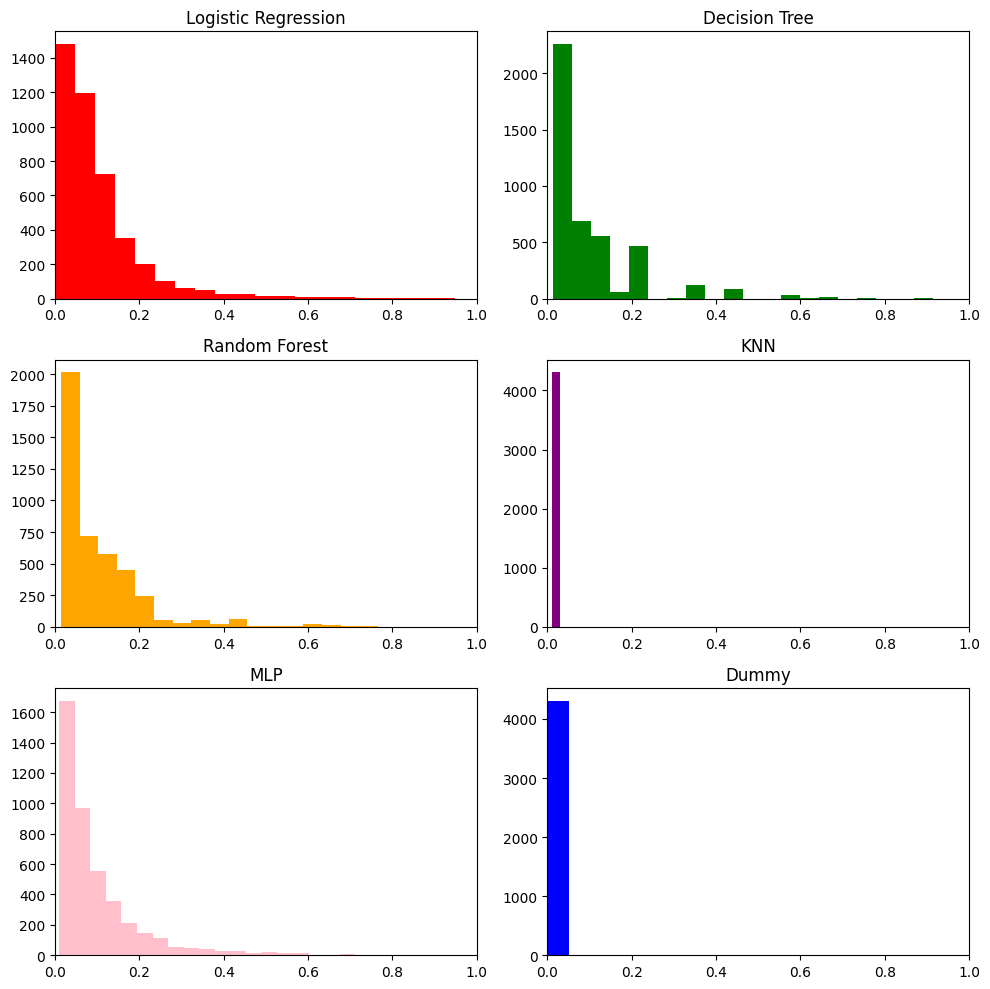

In [398]:
# Distribution des prédictions
# des différents modèles


proba_log_reg = y_pred_log_reg[:, 1]
proba_tree = y_pred_tree[:, 1]
proba_forest = y_pred_forest[:, 1]
proba_knn = y_pred_knn[:, 1]
proba_mlp = y_pred_mlp[:, 1]
proba_dummy = y_pred_dummy[:, 1]

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# On va montrer la distribution des prédictions en utilisant un histogramme

ax[0, 0].hist(proba_log_reg, bins=20, color="red")
ax[0, 0].set_title("Logistic Regression")
ax[0, 0].set_xlim(0, 1)

ax[0, 1].hist(proba_tree, bins=20, color="green")
ax[0, 1].set_title("Decision Tree")
ax[0, 1].set_xlim(0, 1)

ax[1, 0].hist(proba_forest, bins=20, color="orange")
ax[1, 0].set_title("Random Forest")
ax[1, 0].set_xlim(0, 1)

ax[1, 1].hist(proba_knn, bins=20, color="purple")
ax[1, 1].set_title("KNN")
ax[1, 1].set_xlim(0, 1)

ax[2, 0].hist(proba_mlp, bins=20, color="pink")
ax[2, 0].set_title("MLP")
ax[2, 0].set_xlim(0, 1)

ax[2, 1].hist(proba_dummy, bins=20, color="blue")
ax[2, 1].set_title("Dummy")
ax[2, 1].set_xlim(0, 1)

plt.tight_layout()

# Affichage du meilleur modèle sur un terrain
Le meilleur modèle si on observe notre test de performance est la régression logistique.


In [455]:
# On va prendre toutes les positions possible sur le terrain
# et on va calculer la probabilité de marquer un but
# pour la régression logistique

X = np.array([[x, y] for x in range(105) for y in range(68)])
# On y ajoute que les tirs sont jamais fait de la tête
X = np.hstack((X, np.zeros((X.shape[0], 1))))
# On y ajoute également le fait que c'est systématiquement le pied fort
X = np.hstack((X, np.ones((X.shape[0], 1))))
# On insère dans un dataframe
X = pd.DataFrame(X, columns=["x", "y", "header", "good_foot_used"])

# Il faut transformer les données pour avoir la distance et l'angle

# Pour chaque valeur de Y, on va calculer la distance en Y par rapport au milieu du terrain
# En sachant que 34 est le milieu du terrain
X["C"] = np.abs(X["y"] - 34)
X["distance"] = np.sqrt(X["C"] ** 2 + X["x"] ** 2)
X["angle"] = np.pi - \
                    (np.arctan( (X["C"] - goal_width/2) / X["x"]) + np.pi/2) - \
                    (np.pi/2 - np.arctan( (X["C"] + goal_width/2) / X["x"]))





In [456]:
# On va maintenant créer une heatmap pour visualiser les résultats
# Le but sera de montrer sur chaque position du terrain la probabilité 
# de marquer un but

# On va créer un tableau de 105x68
# Chaque case contiendra la probabilité de marquer un but
# pour la position correspondante

def create_an_heatmap_based_on_predictions(result_predictions, model_name):
    heatmap = np.zeros((105, 68))

    # On va maintenant remplir le tableau
    # avec les probabilités de marquer un but
    # pour chaque position
    for i in range(105):
        for j in range(68):
            # On va chercher la probabilité de marquer un but
            # pour la position (i, j)
            # On va chercher l'index correspondant dans le tableau X
            index = X[(X["x"] == i) & (X["y"] == j)].index[0]
            # On va chercher la probabilité de marquer un but
            # pour la position (i, j)
            proba = result_predictions[index][1]
            # On ajoute la probabilité dans le tableau
            heatmap[i, j] = proba

    # On va maintenant afficher la heatmap
    custom_pitch = VerticalPitch(pitch_type='custom', pitch_length=105, pitch_width=68, pitch_color='white')
    fig, ax = custom_pitch.draw(figsize=(10, 6))

    # Création d'une colormap personnalisée avec du blanc pour les valeurs proches de zéro
    cmap_colors = [(0, 'white'), (0.2, 'orange'), (1, 'red')]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)


    # Affichage de la heatmap
    heatmap_img = ax.imshow(heatmap, cmap=cmap, origin='upper', alpha=0.8)
    ax.set_title("Heatmap des probabilités de marquer un but (" + model_name + ")" )
    plt.colorbar(heatmap_img, ax=ax, label='Probabilité')
    plt.show()



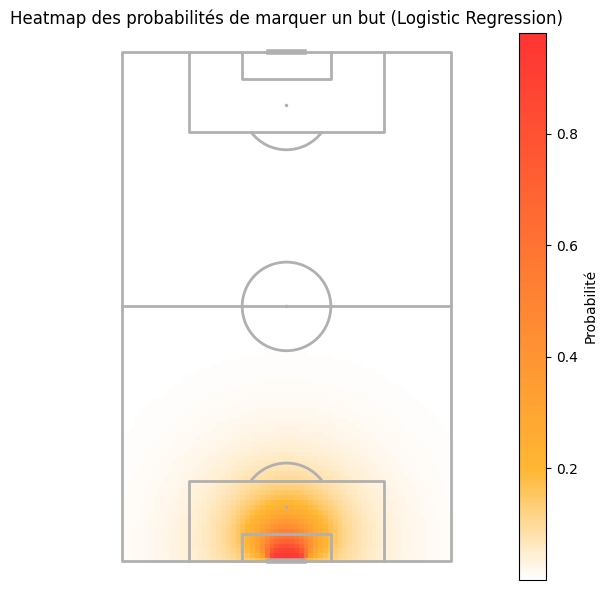

In [457]:
X_for_prob = X[["distance", "angle", "header", "good_foot_used"]]

y_pred_log_reg = log_reg.predict_proba(X_for_prob)


create_an_heatmap_based_on_predictions(y_pred_log_reg, "Logistic Regression", )

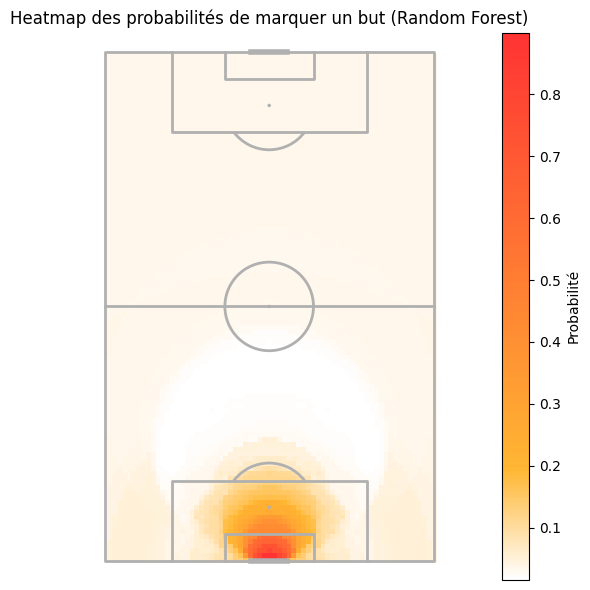

In [458]:
X_for_prob = X[["distance", "angle", "header", "good_foot_used"]]

y_pred_random_forest = forest.predict_proba(X_for_prob)


create_an_heatmap_based_on_predictions(y_pred_random_forest, "Random Forest", )

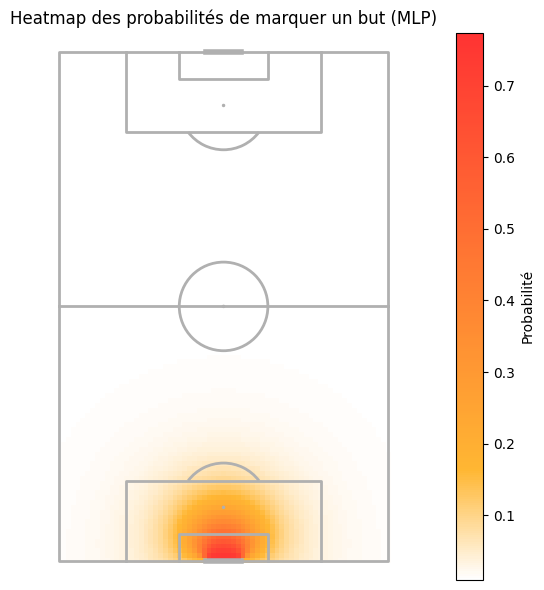

In [459]:
X_for_prob = X[["distance", "angle", "header", "good_foot_used"]]

y_pred_mlp = mlp.predict_proba(X_for_prob)

create_an_heatmap_based_on_predictions(y_pred_mlp, "MLP", )

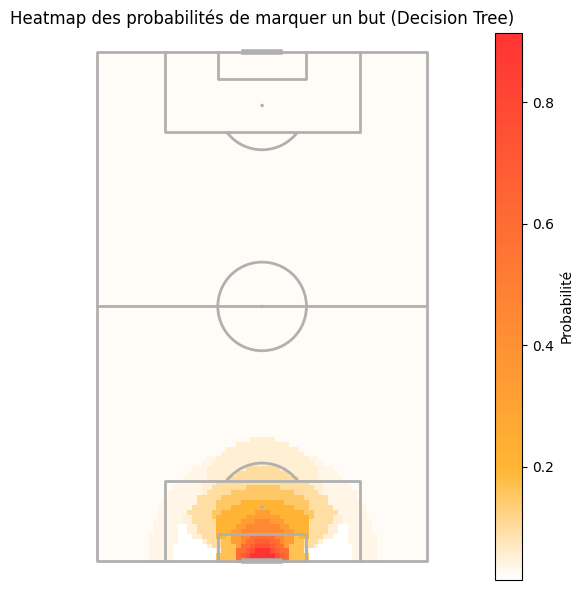

In [460]:
X_for_prob = X[["distance", "angle", "header", "good_foot_used"]]

y_pred_tree = tree.predict_proba(X_for_prob)

create_an_heatmap_based_on_predictions(y_pred_tree, "Decision Tree", )

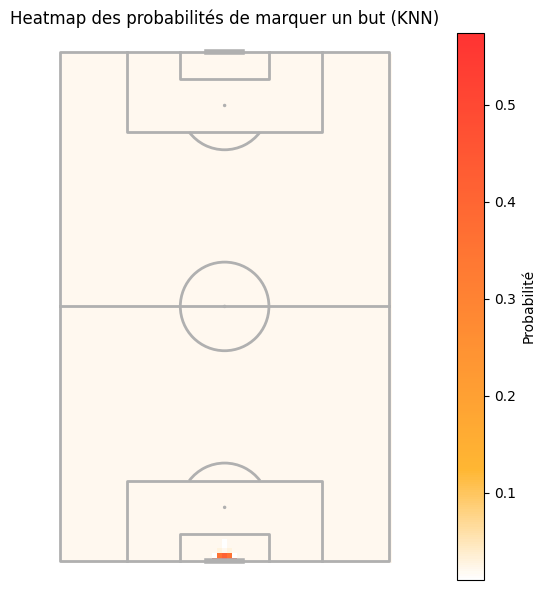

In [461]:
X_for_prob = X[["distance", "angle", "header", "good_foot_used"]]

y_pred_knn = knn.predict_proba(X_for_prob)

create_an_heatmap_based_on_predictions(y_pred_knn, "KNN", )